# Applied Machine Learning: In-class Exercise 07-1

## Goal

In this exercise, we will create a machine learning model that predicts the credit risk of an individual (e.g., the probability of being a good or bad credit applicant for the bank). Our goal is not to obtain an optimal classifier for this task, but to learn how to get a better understanding of the predictions made by this model. This means looking at its sensitivity (ability to correctly identify positives) and specificity (ability to correctly identify negatives). The sensitivity is also known as the true positive rate (TPR) and the specificity is equal to (1 - FPR) where FPR is the false positive rate.

We will also cover how to obtain different response predictions from a probabilistic model by modifying the threshold. We will inspect this relationship via the ROC curve and tune the threshold for a given classifier to optimize our response predictions.

## 1 Training a classification tree on the German credit task

First, load the pre-defined German credit dataset from OpenML and set the positive class to `"good"`. Train a random forest classifier on 2/3 of the data (training data) and make probabilistic predictions on the remaining 1/3 (test data).

<details><summary>Hint 1:</summary>

To do this, you will:

- Load the data using `fetch_openml()`.

- Convert categorical variables to dummy variables using `pd.get_dummies()`.

- Split the data into training and test sets using `train_test_split()`.

- Train a random forest classifier using `RandomForestClassifier()`.

- Obtain probabilistic predictions on the test data using `predict_proba()`.

- Extract the probability of the positive class `"good"`.

</details>

In [1]:
#===SOLUTION===

import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split


X, y = fetch_openml("credit-g", version=1, as_frame=True, return_X_y=True)

X = pd.get_dummies(X, drop_first=True)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=1/3, random_state=42
)

print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

pred_probs = model.predict_proba(X_test)

classes = model.classes_
positive_idx = list(model.classes_).index("good")
probs_good = pred_probs[:, positive_idx]


Training data shape: (666, 48)
Test data shape: (334, 48)


## 2 Confusion matrices and classification thresholds

Inspect and save the confusion matrix of the predictions made in the previous exercise. Manually calculate the FPR and TPR using the values from the confusion matrix. Can you think of another way to compute the TPR and FPR using `scikit-learn` instead of manually computing them using the confusion matrix?

### Recap

A confusion matrix is a special kind of contingency table with two dimensions “actual” and “predicted” to summarize the ground truth classes (truth) vs. the predicted classes of a classifier (response).

Binary classifiers can be understood as first predicting a score (possibly a probability) and then classifying all instances with a score greater than a certain threshold $t$ as positive and all others as negative. This means that one can obtain different class predictions using different threshold values $t$.

<details><summary>Hint 1:</summary>
Use the `confusion_matrix()` function from `sklearn.metrics` to create a confusion matrix. You can specify the `labels` argument to ensure that the matrix aligns with the positive class `"good"`. The TPR is computed as \( P(\hat{Y} = \text{good} \mid Y = \text{good}) \) and the FPR as \( P(\hat{Y} = \text{good} \mid Y = \text{bad}) \).
</details>

<details><summary>Hint 2:</summary>
`recall_score` can also compute the TPR.
</details>

In [2]:
#===SOLUTION===

from sklearn.metrics import confusion_matrix, recall_score

# Generate predicted classes on the test set (default threshold = 0.5)
pred_class = model.predict(X_test)

# Create a confusion matrix with the order of classes specified so that
# the first row/column corresponds to the positive class "good" and the
# second to the negative class "bad".
cm = confusion_matrix(y_test, pred_class, labels=["good", "bad"])
print("Confusion Matrix:")
print(cm)

# In the confusion matrix:
#   - Row 0: Actual "good" instances
#   - Row 1: Actual "bad" instances
#   - Column 0: Predicted as "good"
#   - Column 1: Predicted as "bad"
TP = cm[0, 0]  
FN = cm[0, 1] 
FP = cm[1, 0]  
TN = cm[1, 1]  

# Manually compute TPR (sensitivity) and FPR:
TPR_manual = TP / (TP + FN) 
FPR_manual = FP / (FP + TN) 
print(f"Manual TPR: {TPR_manual:.4f}")
print(f"Manual FPR: {FPR_manual:.4f}")

TPR_recall = recall_score(y_test, pred_class, pos_label="good")
print(f"recall_score TPR: {TPR_recall:.4f}")


Confusion Matrix:
[[215  17]
 [ 65  37]]
Manual TPR: 0.9267
Manual FPR: 0.6373
recall_score TPR: 0.9267


## 3 Asymmetric costs

Think about which type of error is worse for the given task and obtain new predictions (without retraining the model) that take this into account. You can get the new predictions by adjusting the threshold for determining the "good" class.

Then calculate the FPR and TPR and compare them with the results from the previous exercise.

<details><summary>Hint 1:</summary>
Use `np.where()` to assign the class `"good"` only if the predicted probability is larger than the new threshold (e.g., `0.7`). All other instances should be classified as `"bad"`. Then, use `confusion_matrix()` again to recompute the confusion matrix.
</details>

===SOLUTION===

In this credit risk scenario, the error of classifying someone who is not creditworthy (`bad`) as creditworthy (`good`) is typically more serious than the reverse. In the first case, the bank may lose money due to unpaid loans, whereas in the second case, it only misses out on potential profit. 

We can take this fact into account by adjusting the threshold used to classify applicants as `"good"`. For illustration purposes, we will use a threshold of `0.7`, which is more conservative compared to the default threshold of `0.5`.

In [3]:
#===SOLUTION===

threshold_new = 0.7
pred_class_new = np.where(probs_good >= threshold_new, "good", "bad")

cm_new = confusion_matrix(y_test, pred_class_new, labels=["good", "bad"])
print("Confusion Matrix with threshold 0.7:")
print(cm_new)

TP_new = cm_new[0, 0]  
FN_new = cm_new[0, 1] 
FP_new = cm_new[1, 0]
TN_new = cm_new[1, 1]

TPR_new = TP_new / (TP_new + FN_new) 
FPR_new = FP_new / (FP_new + TN_new)    

print(f"TPR with threshold {threshold_new}: {TPR_new:.4f}")
print(f"FPR with threshold {threshold_new}: {FPR_new:.4f}")

cm_default = confusion_matrix(y_test, model.predict(X_test), labels=["good", "bad"])
TP = cm_default[0, 0]
FN = cm_default[0, 1]
FP = cm_default[1, 0]
TN = cm_default[1, 1]
TPR_default = TP / (TP + FN)
FPR_default = FP / (FP + TN)

print(f"\nTPR with default threshold (0.5): {TPR_default:.4f}")
print(f"FPR with default threshold (0.5): {FPR_default:.4f}")

print(f"\nDifference in TPR (new - default): {TPR_new - TPR_default:.4f}")
print(f"Difference in FPR (new - default): {FPR_new - FPR_default:.4f}")

Confusion Matrix with threshold 0.7:
[[157  75]
 [ 27  75]]
TPR with threshold 0.7: 0.6767
FPR with threshold 0.7: 0.2647

TPR with default threshold (0.5): 0.9267
FPR with default threshold (0.5): 0.6373

Difference in TPR (new - default): -0.2500
Difference in FPR (new - default): -0.3725


## ROC Curve

In the previous two exercises, we have calculated the FPR and TPR for two specific thresholds. Now, visualize the FPR and TPR for *all possible thresholds*, i.e., the ROC curve.

### Recap

The receiver operating characteristic (ROC) curve displays the sensitivity (TPR) and (1 - specificity) for all possible thresholds, showing the trade-off between TPR and FPR.


<details><summary>Hint 1:</summary>
First, use `roc_curve(y_test, probs_good, pos_label="good")` to get the values for plotting.
</details>

<Figure size 800x600 with 0 Axes>

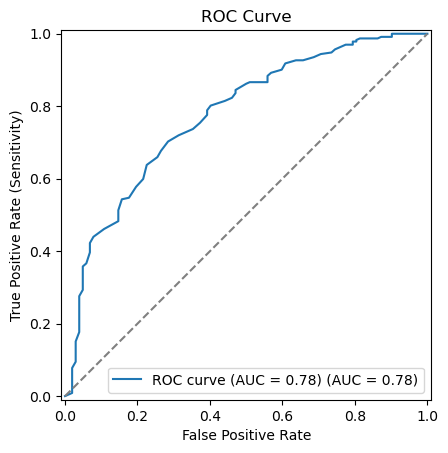

In [4]:
#===SOLUTION===

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay

y_test_binary = (y_test == "good").astype(int)
roc_auc = roc_auc_score(y_test_binary, probs_good)

plt.figure(figsize=(8, 6))
RocCurveDisplay.from_predictions(
    y_test, 
    probs_good,
    pos_label="good",
    name=f"ROC curve (AUC = {roc_auc:.2f})"
)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.title("ROC Curve")
plt.show()


## 5 Threshold tuning

In this exercise, we assume that predicting a false positive is **4 times worse** than predicting a false negative. Use a measure that considers classification costs and tune the threshold of your classifier to systematically optimize the asymmetric cost function. 


### 5.1 Cost Matrix

First, define the cost matrix. Here, this is a 2x2 matrix with rows corresponding to the predicted class and columns corresponding to the true class. The first row/column implies `"good"`, the second `"bad"` credit rating.

In [5]:
#===SOLUTION===

# Define the cost matrix as a 2x2 ndarray
# Rows represent predicted class (0: "good", 1: "bad")
# Columns represent true class (0: "good", 1: "bad")
# - Correct predictions cost 0.
# - False negative (actual "good", predicted "bad") costs 1.
# - False positive (actual "bad", predicted "good") costs 4.
cost_matrix = np.array([
    [0, 4],
    [1, 0]
])

### 5.2 Cost-Sensitive Measure

Next, define a function `cost_sensitive_clf_error(y_true: np.ndarray, pred: np.ndarray, cost_matrix: np.ndarray) -> float` to compute the cost-sensitive mis-classification error. 

In [6]:
#===SOLUTION===

def cost_sensitive_clf_error(y_true, pred, cost_matrix):
    """
    Computes the average misclassification cost given the true labels and predictions.
    
    Parameters:
        y_true (pd.Series): Actual class labels.
        pred (np.ndarray): Predicted class labels.
        cost_matrix (np.ndarray): 2x2 array where rows are predicted class (0: "good", 1: "bad")
                                 and columns are true class (0: "good", 1: "bad").
    
    Returns:
        float: The average cost over all observations.
    """
    # Convert string labels to numeric indices
    y_true_idx = np.where(y_true == "good", 0, 1)
    pred_idx = np.where(pred == "good", 0, 1)
    costs = cost_matrix[pred_idx, y_true_idx]
    return costs.mean()

### 5.3 Thresholding

In default settings, a model will classify a customer as good credit if the predicted probability is greater than 0.5. Here, this might not be a sensible approach as we would likely act more conservatively and reject more credit applications with a higher threshold due to the non-uniform costs. 

Loop over a sequence of thresholds, e.g., `np.arange(0, 1.01, 0.01)`, then compute the average cost-sensitive misclassification error. Finally, visualize how the cost varies with the threshold and mark the optimal threshold on the plot.

<details><summary>Hint 1:</summary>
For each threshold, predict `"good"` if `probs_good >= threshold`, otherwise `"bad"`.
</details>

Default threshold (0.5): TPR = 0.9267, FPR = 0.6569
Default threshold (0.5) cost: 0.8533
Best threshold (0.80): TPR = 0.4397, FPR = 0.0784
Best threshold (0.80) cost: 0.4850


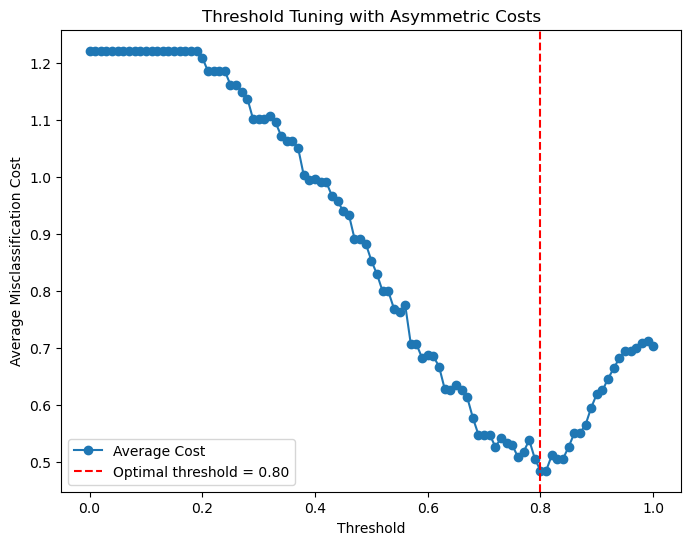

In [7]:
#===SOLUTION===

# Define thresholds from 0 to 1 with step 0.01
thresholds = np.arange(0, 1.01, 0.01)

# Evaluate cost for each threshold
scores = []
for thr in thresholds:
    # Predict "good" if the probability is >= thr, otherwise "bad"
    pred_thr = np.where(probs_good >= thr, "good", "bad")
    score = cost_sensitive_clf_error(y_test, pred_thr, cost_matrix)
    scores.append(score)
scores = np.array(scores)

# Identify the threshold that minimizes the average cost
best_index = scores.argmin()
best_threshold = thresholds[best_index]
best_cost = scores[best_index]

# For comparison, compute confusion metrics for default (0.5) and best threshold.
pred_default = np.where(probs_good >= 0.5, "good", "bad")
cm_default = confusion_matrix(y_test, pred_default, labels=["good", "bad"])
TP_def, FN_def = cm_default[0, 0], cm_default[0, 1]
FP_def, TN_def = cm_default[1, 0], cm_default[1, 1]
TPR_def = TP_def / (TP_def + FN_def)
FPR_def = FP_def / (FP_def + TN_def)
print(f"Default threshold (0.5): TPR = {TPR_def:.4f}, FPR = {FPR_def:.4f}")
cost_default = cost_sensitive_clf_error(y_test, pred_default, cost_matrix)
print(f"Default threshold (0.5) cost: {cost_default:.4f}")

# Best threshold predictions
pred_best = np.where(probs_good >= best_threshold, "good", "bad")
cm_best = confusion_matrix(y_test, pred_best, labels=["good", "bad"])
TP_best, FN_best = cm_best[0, 0], cm_best[0, 1]
FP_best, TN_best = cm_best[1, 0], cm_best[1, 1]
TPR_best = TP_best / (TP_best + FN_best)
FPR_best = FP_best / (FP_best + TN_best)
print(f"Best threshold ({best_threshold:.2f}): TPR = {TPR_best:.4f}, FPR = {FPR_best:.4f}")
print(f"Best threshold ({best_threshold:.2f}) cost: {best_cost:.4f}")

# Plot the cost scores over all thresholds
plt.figure(figsize=(8, 6))
plt.plot(thresholds, scores, marker='o', linestyle='-', label="Average Cost")
plt.axvline(best_threshold, color='red', linestyle='--', label=f"Optimal threshold = {best_threshold:.2f}")
plt.xlabel("Threshold")
plt.ylabel("Average Misclassification Cost")
plt.title("Threshold Tuning with Asymmetric Costs")
plt.legend()
plt.show()


Question: what is your observation?

===SOLUTION===

As expected, the optimal threshold is greater than 0.5 which means the optimal model should predict ‘bad’ credit more often than not.

### 5.4 Tuning the Threshold

Threshold tuning in cost-sensitive classification can be automated using the [`TunedThresholdClassifierCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TunedThresholdClassifierCV.html) class from `scikit-learn.model_selection`. This class automatically identifies the optimal decision threshold via cross-validation to minimize a user-defined cost function.

Set up a `TunedThresholdClassifierCV` using logistic regression along with your cost-sensitive scorer. Evaluate its performance against a standard logistic regression model using 3-fold cross-validation, and compare their average cost-sensitive misclassification errors.

<details><summary>Hint 1:</summary>

Use `make_scorer` to convert your `cost_sensitive_clf_error` function into a scorer. This scorer should be used both:

* **for inner cross-validation** within `TunedThresholdClassifierCV` (to find the optimal threshold), and

* **for outer cross-validation** with `cross_val_score` (to benchmark classification performance).

Note: `make_scorer` expects the scoring function to accept arguments in the form `(y_true, y_pred)`.

</details>

<details><summary>Hint 2:</summary>

Using the default hyperparameters for logistic regression may lead to convergence warning. Therefore, it is recommended to use the following hyperparameters for logistic regression.

```python
log_reg_params = {
    'max_iter': 1000,
    'solver': 'liblinear',
}
```


</details>


In [8]:
#===SOLUTION===

from sklearn.model_selection import TunedThresholdClassifierCV, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer


def cost_sensitive_scorer_func(y_true, y_pred):
    """Custom scorer function that returns the negative cost (since sklearn maximizes scores)."""
    return -cost_sensitive_clf_error(y_true, y_pred, cost_matrix)

# Create the scorer object - use this for both TunedThresholdClassifierCV and cross_val_score
cost_scorer = make_scorer(cost_sensitive_scorer_func, greater_is_better=True)

log_reg_params = {
    'max_iter': 1000,
    'solver': 'liblinear',
    'random_state': 42
}

# Create base classifier to be used in TunedThresholdClassifierCV
base_classifier = LogisticRegression(**log_reg_params)

# Create learners dictionary
learners = {
    'threshold_tuned_log_reg': TunedThresholdClassifierCV(
        estimator=base_classifier,
        scoring=cost_scorer,
        cv=3,
        thresholds=100
    ),
    'log_reg': LogisticRegression(**log_reg_params)
}

# Set up 3-fold cross-validation for benchmarking
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

results = {}
for name, learner in learners.items():
    scores = cross_val_score(learner, X_train, y_train, cv=cv, 
                           scoring=cost_scorer, n_jobs=-1) 
    # Convert back to cost (from negative score)
    avg_cost = -scores.mean()
    results[name] = avg_cost

print(f"Benchmark Results:\n{'learner_id':<35} {'costs':<15}\n{'-' * 50}")
for learner_id, cost in results.items():
    print(f"{learner_id:<35} {cost:<15.7f}")

# Fit the tuned threshold classifier to get the optimal threshold
tuned_clf = learners['threshold_tuned_log_reg']
tuned_clf.fit(X_train, y_train)
print(f"\nOptimal threshold: {tuned_clf.best_threshold_:.4f}")

Benchmark Results:
learner_id                          costs          
--------------------------------------------------
threshold_tuned_log_reg             0.5510511      
log_reg                             0.7252252      

Optimal threshold: 0.7289


## 6 & 7 ROC and AUROC Comparison

In this exercise, we will explore how to compare two learners by looking at their ROC curves.

The basis for this exercise will be a benchmark experiment comparing a Decision Tree classifier with a Random Forest classifier on the German credit dataset.

Since we are now not only focused on the analysis of a single prediction but on the comparison of two learners, we will use 10-fold cross-validation to reduce the uncertainty of the comparison.

Conduct the benchmark experiment and show both ROC curves in one plot. Which learner performs better in this case?

Also compare the AUROCs derived from these learners using boxplots.


<details><summary>Hint 1:</summary>
Aggregate the ROC curves across the 10 folds for each learner by interpolating and averaging the TPRs. To visualize the variability, you can also plot a shaded area showing ±1 standard deviation around the mean ROC curve. Finally, plot both ROC curves in the same plot to compare their performances.
</details>


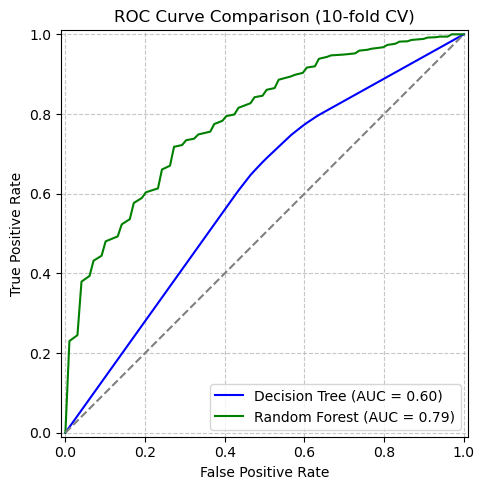

In [9]:
#===SOLUTION===

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import RocCurveDisplay

learners = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42)
}

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

roc_data = {name: [] for name in learners.keys()}
auc_values = {name: [] for name in learners.keys()}

for learner_name, learner in learners.items():
    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        learner.fit(X_train, y_train)
        probs = learner.predict_proba(X_test)
        pos_idx = list(learner.classes_).index("good")
        probs_good = probs[:, pos_idx]
        
        fpr, tpr, thresholds = roc_curve(y_test, probs_good, pos_label="good")
        auc_value = roc_auc_score((y_test == "good").astype(int), probs_good)
        
        roc_data[learner_name].append((fpr, tpr, thresholds))
        auc_values[learner_name].append(auc_value)

# Create a figure for the ROC curve plot
plt.figure(figsize=(5, 5))

# Colors for the different learners
colors = {"Decision Tree": "blue", "Random Forest": "green"}

for learner_name in learners.keys():
    mean_fpr = np.linspace(0, 1, 100)
    interp_tprs = []
    
    for fpr, tpr, _ in roc_data[learner_name]:
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        interp_tprs.append(interp_tpr)
    
    mean_tpr = np.mean(interp_tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = np.mean(auc_values[learner_name])
    
    RocCurveDisplay(
        fpr=mean_fpr,
        tpr=mean_tpr,
        roc_auc=mean_auc,
        estimator_name=learner_name
    ).plot(ax=plt.gca(), color=colors[learner_name])

plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison (10-fold CV)")
plt.legend(loc="lower right")
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


Question: Which learner performs better?

===SOLUTION===

The random forest is clearly better, as for virtually every specificity it has a higher sensitivity.

## Bonus exercise: Unbiased performance estimation

Revisit the exercise where we tuned the threshold. Is the performance estimate for the best threshold unbiased? If no, does this mean that our tuning strategy was invalid?

<details><summary>Hint 1:</summary>
Did we use an independent test set?
</details>

<details><summary>Hint 2:</summary>
Think of the uncertainty when estimating the ROC curve.
</details>

===SOLUTION===

No, although our method is valid with respect to determining our “best guess” for the optimal threshold, the obtained performance estimate suffers from optimization bias. We would need an independent test set to evaluate our method, i.e. nested holdout or cross-validation.

## Summary

In this exercise we improved our understanding of the performance of binary classifiers by the means of the confusion matrix and a focus on different error types. We have seen how we can analyze and compare classifiers using the ROC and how to improve our response predictions using threshold tuning.